# Assignment Description

In this Assignment, you will be asked to implement a simple coverage-guided fuzzer. Fuzzing is commonly used to uncover various types of bugs (e.g., security) and has received much attention from both the industry and academia. You do not need to implement the fuzzer from scratch. In this Jupyter notebook file, we will walk you through some of the basic steps before you implement your own fuzzer. The objectives and submission of this assignment can be found near the end of this file.

Note: A lot of the contents are taken from the [fuzzing book](https://www.fuzzingbook.org) with some modifications.

# Let's start by installing some dependencies!

The code below installs the dependency in Jupyter only. A recommended way is to run "pip install fuzzingbook" on the command line.

In [25]:
import sys
!{sys.executable} -m pip install fuzzingbook

In [26]:
import sys
!{sys.executable} -m pip install validators

In [54]:
import sys
!{sys.executable} -m pip install IPy

  Created wheel for IPy: filename=IPy-1.0-py3-none-any.whl size=21144 sha256=9d3ba8d5f6a4910b7aa5ce080bd734bd20b21a99f1c44c2016adb65355a2bb9f
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\c0\d4\6b\a2f002ae5039ff6698980ffa0fe0a0ede66765bea8add246f7
Successfully built IPy


# A Simple Random Fuzzer

Now, let's use the library provided in the fuzzingbook to get a very simple fuzzer: a random fuzzer.

In [28]:
from fuzzingbook.Fuzzer import RandomFuzzer
random_fuzzer = RandomFuzzer()
random_fuzzer.fuzz()

"8(4=7'>*'83'5/!-4',?8+0#1,<"

The output is a randomly generated string, which can be used as an input for other programs.

We can also look at the implementation of RandomFuzzer:

In [29]:
import inspect
from fuzzingbook.fuzzingbook_utils import print_content

print_content(inspect.getsource(RandomFuzzer))

class RandomFuzzer(Fuzzer):
    def __init__(self, min_length=10, max_length=100,
                 char_start=32, char_range=32):
        """Produce strings of `min_length` to `max_length` characters
           in the range [`char_start`, `char_start` + `char_range`]"""
        self.min_length = min_length
        self.max_length = max_length
        self.char_start = char_start
        self.char_range = char_range

    def fuzz(self):
        string_length = random.randrange(self.min_length, self.max_length + 1)
        out = ""
        for i in range(0, string_length):
            out += chr(random.randrange(self.char_start,
                                        self.char_start + self.char_range))
        return out


The fuzzer simply generates a random string with a default length between 10 and 100.

## Example: Finding Buffer Overflow
Let's see how this fuzzer can be useful through a simple simulated example. In C, we often need to specify the length of the characters that we need to read. If the actual length is longer than the specified length, it can cause buffer overflow. (The example is taken from the [fuzzing book](https://www.fuzzingbook.org))

```c
char weekday[10]; // 9 characters + trailing '\0' terminator
strcpy (weekday, input);
```

We can simulate this problem in Python as: 

In [14]:
def crash_if_too_long(s):
    if len(s) > 9: # 9 characters
        raise ValueError

Now, let's generate tests for this program.

In [30]:
import traceback # to get the stack trace

trials = 100
for i in range(0, trials):
    inp = random_fuzzer.fuzz()
    print ("trial: %s with input: %s" % (i, inp))
    try: 
        crash_if_too_long(inp)
    except ValueError:
        traceback.print_exc()
        break

trial: 0 with input: =0,(6%7*78< ;,#*$2.1(<,!4).5>;,%#;6/492%1;57>$4 1%80


Traceback (most recent call last):
  File "<ipython-input-30-9e514079d094>", line 8, in <module>
    crash_if_too_long(inp)
  File "<ipython-input-14-82d8cf6c68ac>", line 3, in crash_if_too_long
    raise ValueError
ValueError


As we can see, our very simple fuzzer is able to trigger the (simulated) bug. These kinds of bug may lead to security issues. Many companes nowadays use fuzzing to help them detect bugs.

For example, Google uses fuzzing and open sourced their fuzzing tool: [OSS Fuzz](https://github.com/google/oss-fuzz). As mentioned by Google, so far, OSS Fuzz has detected more than 14,000 bugs in 200 open source systems.

Other popular fuzzing tools include: [AFL](https://github.com/google/AFL), [LibFuzzer](https://llvm.org/docs/LibFuzzer.html), and many more. In particular, AFL is one of the most popular and most extended fuzzer. Many research papers are built upon AFL. 

## Testing a Simple URL Parser

Let's use our simple fuzzer to test a simple URL parser in Python.

In [31]:
from urllib.parse import urlparse

def http_program(url):
    supported_schemes = ["http", "https"]
    result = urlparse(url)
   #print(result)
    #print(result.scheme)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of " + repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("Host must be non-empty")

    # Do something with the URL
    return True  

For now, we assume that our goal is to test if we can generate both valid and invliad inputs for the program. We can use the following code:

In [32]:
def is_valid_url(url):
    try:
        result = http_program(url)
        return True
    except ValueError:
        return False


Then, we use our random fuzzer to test the program. 

In [33]:
random_fuzzer = RandomFuzzer()

valid_inputs = set()
trials = 20

for i in range(trials):
    inp = random_fuzzer.fuzz()
    print ("input is " + inp)
    if is_valid_url(inp):
        valid_inputs.add(inp) 

len(valid_inputs) / trials

input is !0>6:"&68;(78,$679 (."8<543(<)//8*
input is /;?>#2*"1.<%/58>;%:2)&;/-$ *,9469.+*9*--"97;7';-1+*<!.8$'?"&:*"+*"!5/$9-<(.2<014#>  "%
input is  -:!,'.+-33"%5;348"0#!9=+8<65-73)=79"7->#<*3;+9#9,%3,<<%=<>?%:9<10%%*%/%: =9&4
input is &36692$0<1++3* ;,!+#31)346;*/474'
input is 4+%#%3 /2!88 *'/->?>7,9"$9:1 &1(;".;/*0.783'.*=8-'62*=7:4.$/9%!:%#
input is 4:+6="#38")2 <)4,+>*#-**>2':>9!!7/6#8*:8!-0?4*9;!?'!?(%*'1/8119<61&.?;</;)+7.$";8+<?/" "/,(=
input is *%&5--2;!+>&.8;*1*4/%18./>0>;)*8'?1;8?0>38!9%1:<,54.4#5,+.5:42/.-3&&3(#+40<2;4)'):6:*=:56--"1540
input is 186111>3/5#3:48!'+2-#?;(--(?>#<8->2.%0&&:583425# (#?;)0 2<1), 9;%(5?1-5.8=740:',&37
input is ('>,65=>-759- ?0?.65, 71;$596"6!)4>0 $2; ';$%=* 6) ""?:&=',0+/<587? ?+%&3.,)!17681434 >#1+:376!//
input is %6 5#3&!.%;+.;$;;=+<<(;:.$65&=151%21"14: 4,*:-1=+4=$%35-'44%4%%+0)60.8>;7&519+?=!14"&*&!#2941=4$0.
input is ,43"&'46<2#(*9.>33;6>>#"-/$?;:8&5)5&8%35':31698+*'0>32.?-;3!$
input is 917:!'%"9#9%!!
input is ?4;26$='/:$'.);%>  >9,?/6<76<'))(

0.0

As expected, we cannot generate any valid input to test the program. How can we generate smarter inputs?

# Mutation Fuzzer

Randomly generating inputs may not sound so smart. For different programs, we might want a more customized way to automatically generate inputs. 

For example, if we want to test a calculator program, we might not want to generate so many textual inputs. These textual inputs may only increase the test generation time with no additional code coverage (more on this later). 

Now, let's look at some simple mutation operators.

In [34]:
import random

# the code mutates the input by randomly deleting a character
def delete_random_char(s):
    if s == "":
        return s
    pos = random.randint(0, len(s) - 1)
    return s[:pos] + s[pos+1:]

inp = "www.google.com"
delete_random_char(inp)

'www.gogle.com'

In [35]:
# the code mutates the input by randomly adding a character
def add_random_char(s):
    pos = random.randint(0, len(s) - 1)
    random_character = chr(random.randrange(32, 127))
    return s[:pos] + random_character + s[pos:]

inp = "This is an example"
add_random_char(inp)

'This is an {example'

In [21]:
# the code mutates the input by randomly flipping a character
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)
    # print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
    return s[:pos] + new_c + s[pos + 1:]

inp = "This is an example"
flip_random_character(inp)

'This is an exqmple'

We can also apply multiple mutators to an input:

In [36]:
inp = "This is an example"

mutators = [delete_random_char, add_random_char, flip_random_character]

for i in range(0, 10):
    mutator = mutators[random.randint(0, 2)]
    print(inp)
    inp = mutator(inp)
print("final")    
# after 10 random mutations
print (inp)

This is an example
This is an exaple
This is an exapl
this is an exapl
this is an xapl
this 7is an xapl
this 7is }an xapl
this 7is }*an xapl
this wis }*an xapl
thys wis }*an xapl
final
thys $wis }*an xapl


We can also use similar code to fuzz URLs for testing web servers or URL parsers (remember the example that we discussed in the previous section). 

Now, instead of using the code above, we can call the API from the FuzzingBook (the behaviour is the same):

In [37]:
from fuzzingbook.MutationFuzzer import MutationFuzzer
import random
seed = "https://www.concordia.ca/"
mutation_fuzzer = MutationFuzzer(seed=["https://www.concordia.ca/"])
mutation_fuzzer.fuzz()

[mutation_fuzzer.fuzz() for i in range(10)]


['https://www.cmncoia.ca/',
 'tt:pfs://wwwkoNcGrdJi.ca/',
 'jGtts://wwconc8o rde.ca/',
 'https:\x7fww.RwonCordia.caT/',
 'http://w}ww.1concoYrdia.ca/',
 'httpQsv:/wwwg.ctoncorNdiaE.cSa/',
 '`ttpscJ.://www.concordBHia.{ba/',
 'httpsd://www.concrdia.ca/',
 'hPEttps:\x0fwww.cDoncoSrdia.ca/',
 'htt`s://wvw.concopdaV.ca/']

These automatically generated inputs look better than those randomly generated ones. We can use inputs to test the URL parser program for unexpected behvaiour (e.g., exception handling or crashes) or even security issues.

Note that for different problems, you might need to come up with different mutators. For example, if you are testing a calculator program, mutators for strings may not be very effective. 

Let's use our new fuzzer to test our URL parser.

In [38]:
seed = "http://www.concordia.ca"
mutation_fuzzer = MutationFuzzer([seed])

valid_inputs = set()
trials = 20

for i in range(trials):
    inp = mutation_fuzzer.fuzz()
    print ("input " + inp)
    if is_valid_url(inp):
        valid_inputs.add(inp) 

len(valid_inputs) / trials

input http://www.concordia.ca
input ht^vp://wwW.coyncori[.ca
input hvp>/wWw>coUncordia.a
input htpp://www.cRoncordiaca
input h2t://w>wwcnyoria.ca
input http://www.gOncorIdia.ca
input ttNp://7ww.c.cordia.a
input http:+/wsw.concoM=rdia.cx
input xttp:+/www.cO9nc$ordia.ca7
input http:/www.Wcncordia+.ca
input http//N7~g.coNodia.ca
input jhttp://www.cmncordia.ca
input BhVttp://www.concordia.ca
input http:/www.coNncopdia.ci
input htt2p:+/www.conaordia.ca{
input jttp//www.cOncordia.za
input http://Www.conc9ordia.aa
input http://Vwww.cnnckda.aa
input h4tp://www.cocoria.cQa
input http://wws.concda.aca


0.25

This is an improvement. We can now generate valid inputs to test the URL pareser! 

But is there any way that we can do better?

# Using Coverage to Guide Fuzzing

What we have discussed so far belongs to the family of blackbox fuzzing. Namely, we do not have any information of the source code, nor how the code is executed. We can improve our fuzzer by integrating the coverage information. 

We can easily get coverage information in Python. We can setup a trace function as follows (more information can be found [here](https://pymotw.com/3/sys/tracing.html)):

In [39]:
# record which line got executed
coverage = []

def traceit(frame, event, arg):
    if event == "line":
        global coverage
        #func_filename = frame.f_code.co_filename
        function_name = frame.f_code.co_name
        lineno = frame.f_lineno
        #coverage.append((func_filename, function_name, lineno))
        coverage.append((function_name, lineno))

    return traceit

In [40]:
import sys

def execute_and_trace(fun, inp):
    global coverage
    coverage = []
    sys.settrace(traceit)  # Turn on
    fun(inp)
    sys.settrace(None)    # Turn off

inp = "urbashi0931@gmail.com"
execute_and_trace(is_valid_url, inp)
[cov for cov in coverage]

[('is_valid_url', 2),
 ('is_valid_url', 3),
 ('http_program', 4),
 ('http_program', 5),
 ('urlparse', 372),
 ('_coerce_args', 116),
 ('_coerce_args', 117),
 ('_coerce_args', 120),
 ('_coerce_args', 117),
 ('_coerce_args', 122),
 ('_coerce_args', 123),
 ('urlparse', 373),
 ('urlsplit', 423),
 ('_coerce_args', 116),
 ('_coerce_args', 117),
 ('_coerce_args', 120),
 ('_coerce_args', 117),
 ('_coerce_args', 122),
 ('_coerce_args', 123),
 ('urlsplit', 424),
 ('urlsplit', 425),
 ('urlsplit', 426),
 ('urlsplit', 427),
 ('urlsplit', 429),
 ('urlsplit', 431),
 ('urlsplit', 432),
 ('urlsplit', 433),
 ('urlsplit', 460),
 ('urlsplit', 465),
 ('urlsplit', 467),
 ('urlsplit', 469),
 ('_checknetloc', 400),
 ('_checknetloc', 401),
 ('urlsplit', 470),
 ('__new__', 1),
 ('urlsplit', 471),
 ('urlsplit', 472),
 ('_noop', 100),
 ('urlparse', 374),
 ('urlparse', 375),
 ('urlparse', 378),
 ('urlparse', 379),
 ('__new__', 1),
 ('urlparse', 380),
 ('_noop', 100),
 ('http_program', 8),
 ('http_program', 9),
 ('i

We can also use the *Coverage* class from the fuzzing book to achieve the same goal. The code in the fuzzing book simply abstracts the above-mentioned code. 

In [41]:
from fuzzingbook.Coverage import Coverage

inp = "http://www.concordia.ca"

with Coverage() as cov:
    is_valid_url(inp)
    
[c for c in cov.coverage()]

[('urlsplit', 425),
 ('urlsplit', 434),
 ('urlparse', 373),
 ('is_valid_url', 3),
 ('urlsplit', 431),
 ('urlsplit', 437),
 ('urlsplit', 446),
 ('urlparse', 379),
 ('urlsplit', 443),
 ('_checknetloc', 400),
 ('_splitnetloc', 392),
 ('_splitnetloc', 395),
 ('_coerce_args', 116),
 ('_coerce_args', 122),
 ('__exit__', 237),
 ('urlsplit', 427),
 ('urlsplit', 424),
 ('is_valid_url', 2),
 ('urlsplit', 436),
 ('urlparse', 375),
 ('urlsplit', 433),
 ('urlparse', 372),
 ('urlsplit', 439),
 ('urlparse', 378),
 ('http_program', 8),
 ('urlsplit', 448),
 ('http_program', 5),
 ('urlsplit', 445),
 ('http_program', 14),
 ('_splitnetloc', 394),
 ('_splitnetloc', 397),
 ('urlsplit', 423),
 ('urlsplit', 429),
 ('urlsplit', 426),
 ('urlsplit', 432),
 ('is_valid_url', 4),
 ('urlsplit', 435),
 ('urlsplit', 441),
 ('urlparse', 374),
 ('http_program', 4),
 ('urlsplit', 438),
 ('__new__', 1),
 ('urlparse', 380),
 ('_noop', 100),
 ('urlsplit', 447),
 ('http_program', 10),
 ('_checknetloc', 401),
 ('_splitnetloc'

How can the coverage information help us during fuzzing? Let's look at the example below. 

In [42]:
with Coverage() as first_cov:
    is_valid_url("http://www.concordia.ca")
with Coverage() as second_cov:
    # the URL of searching "google" on Google
    is_valid_url("https://www.google.com/search?q=google&rlz=1C5CHFA_enCA758CA758&oq=google&aqs=chrome..69i57j69i60l3j69i65j69i60.4544j0j7&sourceid=chrome&ie=UTF-8")
    
first_cov.coverage() - second_cov.coverage()

{('urlsplit', 428)}

The coverage information for different inputs may be different! Let's see the relationship between input and coverage. 

In [43]:
def calculate_cumulative_coverage(input_population, function):
    cumulative_coverage = []
    all_coverage = set()
    
    for inp in input_population:
        with Coverage() as cov:
            try:
                function(inp)
                #print(all_coverage)
            except:
                # we ignore exceptions for the purpose of this code, but some exceptions may be interesting
                pass
        # set union
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))
        #print(cumulative_coverage)
    return cumulative_coverage


The above code measures the cumulative coverage for a set of inputs (i.e., input_population). Let's test this code by doing some simple fuzzing. 

In [68]:
trials = 15
fuzzer = MutationFuzzer(seed = ["http://www.concordia.ca"])
random_fuzzer = RandomFuzzer().fuzz()
population = []
for i in range(0, trials):
    population.append(fuzzer.fuzz())

cumulative_coverage = calculate_cumulative_coverage(population, is_valid_url)
random_cumulative_coverage = calculate_cumulative_coverage(population, is_valid_url)
cumulative_coverage

[29, 60, 60, 69, 69, 69, 72, 72, 72, 72, 73, 73, 73, 73, 73]

We can also visualize the cumulative coverage.

Text(0, 0.5, 'lines covered')

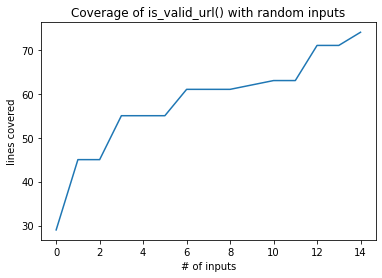

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cumulative_coverage)
plt.title('Coverage of is_valid_url() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')

# Objective 1 - Now it is your turn to construct a coverage-guided fuzzer

You will need to implement a smarter way to create fuzzed input for your program. However, we are still randomly generating fuzzed inputs. In the first part of the assignment, you need to implement an algorithm to be smarter when generating the fuzzed inputs.

* You need to maintain a population (i.e., a list of seeds) that you can use for mutation. Each seed in the
population will be an input that provided additional coverage information.
* You will take a seed from the population and fuzz the seed to test the program. __If the population is empty, you
can mutate an initial seed that you provide manually__.
* __You need to take the seed from the population semi-randomly, but the seeds that provided more additional
coverage have a higher chance of being selected.__
* If the new input increased the coverage, add this new input to the population as a new seed. Assign a score to
the seed (i.e., how much coverage it improved).
* Repeat and go back to Step 2 until you execute your fuzzer X times (i.e., your pre-defined number of trials).

This is an extra mutator object that shuffles a string (i.e email address/URL). It is an extension to the previous mutators that relies on adding/deleting/flipping random characters in a given string

In [46]:
import random
def shuffle_chars(s):
    chars=list(s)
    #print (chars)
    shuffled=random.sample(chars,len(chars)) 
    outputString=""
    outputString=outputString.join(shuffled)
    return outputString

input="urbashi0931@gmail.com"
shuffle_chars(input)

'9gc3m@0hr.uomisabl1ai'

In [47]:
import random
import string
def get_random_punctuation(s):
    length=len(s)
    listofpunctuation = string.punctuation
    result_str = ''.join(random.choice(listofpunctuation) for i in range(length))
    return result_str
s="apple"
get_random_punctuation(s)

'@`&(\\'

In [48]:
from fuzzingbook.Coverage import Coverage

#this function calculates total no of lines covered for a single seed input. This function is used in objective 1
def get_lines_covered(func, arg):
    with Coverage() as cov:
        func(arg)
        
    return (len(cov.coverage()), cov.coverage())

inp = "a.9msmU0bso`c`1ilah"
#get_lines_covered(is_valid_url, inp)

In [83]:

#predefined no of trials 
trial = 2000

my_cumulative_coverage=[]

#mutator list
#each mutator is defined above
mutators = [ delete_random_char,add_random_char,flip_random_character,shuffle_chars,get_random_punctuation]

#actual implementation of objective 1
def get_fuzzy_inputs(func, seed):
    try:
        seed_line_covered ,covered_set = get_lines_covered(func, seed) 
    
        population = [(seed, seed_line_covered)] # [("urbashi0931@gmail.com", 123)]
    
        #looping as of no of trials(last bullet)
        for i in range(trial):
            seeds = [seed[0] for seed in population]
            lines_covered = [seed[1] for seed in population]
        #semi-random selection starts here where lines_covered is a weight    
            seed_choice = random.choices(seeds,lines_covered)
        
        
        #print(seed_choice)
        
        #fuzzer = MutationFuzzer(seed = seed_choice)
       #taking a mutator object from the list of mutators
            mutator = mutators[random.randint(0,4)]
            mutated_seed = mutator(seed_choice[0])
        #mutated_seed = fuzzer.fuzz()
        
        #print(mutated_seed, seed_choice)
        
            mutated_lines_covered, mutated_covered_set = get_lines_covered(func, mutated_seed)
        
    #if the new input increased the coverage, add this new input to the population as a new seed. Assign a score to the seed 
            if len(covered_set | mutated_covered_set) > len(covered_set):
                covered_set |= mutated_covered_set
                population.append((mutated_seed, mutated_lines_covered))
        
            #print(population)
                my_cumulative_coverage.append(len(covered_set))
           # print(len(covered_set))
        
        
    
        return population
#exception handling for possible system crash detection
    except :
        e = sys.exc_info()[0]

#inputs = get_fuzzy_inputs(is_valid_email,'urbashi0931@gmail.com')
#inputs = get_fuzzy_inputs(is_valid_ip,"172.101.245.123.111.001")
#inputs = get_fuzzy_inputs(is_valid_url, "https://www.concordia.ca")
#inputs = get_fuzzy_inputs(cgi_decode,"a+b")
print(inputs)

[('urbashicse@09.com', 16), ("}]'>:-{>_@{+%*<_=", 139), ("'*{@_}_>:]-=+{><%", 151), ("$>'!<``?}*^$&:&:[", 137), ('urbashicse@09.c\x7fm', 152), ('uc9sear0scobmih@.', 152), ('u9eio.0sbharcmsc@', 146)]


# Objective 2 - Testing your fuzzer

You need to run your fuzzer on 3 Python programs. You can choose any reasonable size program that you find (e.g.,
the program cannot be a simple print ’Hello World’). You can find existing programs or you can write the programs
yourself.

For example program, you need to try different fuzzing approaches described above, in addition to the
fuzzer you wrote. You need to discuss and compare each fuzzing approach (e.g., pure randomly vs coverage-guided)
in terms of coverage. You also need to plot how the coverage increases for the inputs that you tried (i.e., the same as the plot illustrated above).

In addition to coverage, if your program found any bug (e.g., unexpected failure or crash), please record it.

In [50]:
#program no 2 to Test 
import validators
def is_valid_email(email):
    try:
        result=validators.email(email)
        return True
    except ValueError: 
            return False

email="urbashicse@gmail.com"
is_valid_email(email)

True

In [55]:
#program no 3 to Test
from IPy import IP
def is_valid_ip(ip):
    try:
        IP(ip)
        return True
    except ValueError:
        return False
is_valid_ip("172.101.245.123.111.001")

False

Text(0, 0.5, 'coverage')

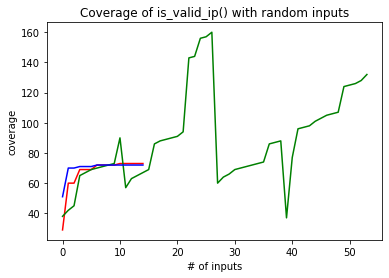

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
inputs = get_fuzzy_inputs(is_valid_ip,"172.101.245.123.111.001")
#this represents Mutation fuzzer and color is RED in the plot
plt.plot(cumulative_coverage,"r")
#this represents My fuzzer and color is green in the plot
plt.plot(my_cumulative_coverage,"g")
#this represents Random fuzzer and color is blue in the plot
plt.plot(random_cumulative_coverage,"b")
plt.title('Coverage of is_valid_ip() with random inputs')
plt.xlabel("# of inputs")
plt.ylabel('coverage')

Text(0, 0.5, 'coverage')

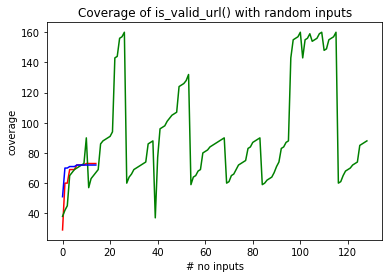

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
#checks coverage for is_valid_url function for a given seed
inputs = get_fuzzy_inputs(is_valid_url,"https://www.concordia.ca")
#this represents Mutation fuzzer and color is RED in the plot
plt.plot(cumulative_coverage,"r")
#this represents My fuzzer and color is green in the plot
plt.plot(my_cumulative_coverage,"g")
#this represents Random fuzzer and color is blue in the plot
plt.plot(random_cumulative_coverage,"b")
plt.title('Coverage of is_valid_url() with random inputs')
plt.xlabel("# no inputs")
plt.ylabel('coverage')

Text(0, 0.5, 'coverage')

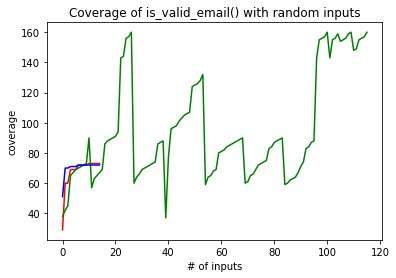

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
#checks coverage for is_valid_url function for a given seed
inputs = get_fuzzy_inputs(is_valid_email,"urbashi0931@gmail.com")
#this represents Mutation fuzzer and color is RED in the plot
plt.plot(cumulative_coverage,"r")
#this represents My fuzzer and color is green in the plot
plt.plot(my_cumulative_coverage,"g")
#this represents Random fuzzer and color is blue in the plot
plt.plot(random_cumulative_coverage,"b")
plt.title('Coverage of is_valid_email() with random inputs')
plt.xlabel("# of inputs")
plt.ylabel('coverage')

# Submission

Your final submission will be the Jupyter file that you worked on. You will submit the Jupyter file to the Moodle. Please include descriptions for different steps that you take when working on the assignment.